# iPython notebook for reading OSKAR visibility binary files

### Description
Notebook demonstrating reading of OSKAR binary format visibility files produced by OSKAR 2.6 and later versions of OSKAR.

Note that baseline coordinates in OSKAR visibility binary files, are stored in metres. This script scales the coordiantes into wavelengths prior to writing to a simple ascii csv format so that they can be gridded directly without scaling in the imaging script.

### To run the script you will need:

- ipython (python 2.7)
- numpy (1.9)
- matplotlib
- read_oskar_vis.py (python module found in the `oskar_data/scripts` sub-directory)
- Example OSKAR simulated binary data (found in the `oskar_data` sub-directory)

**This notebook is intended to be run from the top level crocodile directory.**

### TODO
- Download test data rather than point to data in the repository (requires setting up a web-location for all of the possible test data).
- Test reading of more of the visibility binary meta-data.
- Test reading files containing more than one frequency channel.

In [9]:
%matplotlib nbagg
import sys
import os
import numpy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = 12, 12

sys.path.append(os.path.join('..','..'))
from util.read_oskar_vis import OskarVis

#### 1. Load visibility data.
- Open the OSKAR binary file `test_vla.vis` and extract the coordinates and amplitudes as python arrays.
- Scale coordinates into wavelengths.

In [10]:
# Read visibility binary and scale into wavelengths.
vis_file = os.path.join('data', 'vis', 'vla_grid_6h', 'test_vla.vis')

oskar_vis = OskarVis(vis_file)
uu, vv, ww = oskar_vis.uvw(flatten=True)
freq_hz = oskar_vis.frequency()
wave_length_m = 299792458.0 / freq_hz
uvw = numpy.array([uu, vv, ww]) / wave_length_m
amp = oskar_vis.stokes_i(flatten=True)

#### 2. Save as ASCII format.
- Plain text csv file with columns: uu, vv, ww, real, imag.
- Baselines coordinates are in wavelenghts.
- Amplitudes are Stokes-I flux in Janskys.
- The output is saved alongside the oskar visibility binary file being read but with a '.txt' extension.

In [11]:
file_name = os.path.splitext(vis_file)[0] + '.txt'
data = numpy.empty(shape=(5, amp.shape[0]), dtype='f8')
data[0:3] = uvw
data[3] = amp.real
data[4] = amp.imag
numpy.savetxt(file_name, data.transpose(), fmt='%.12e', delimiter=',')

#### 3. Plot visibility data.

<IPython.core.display.Javascript object>


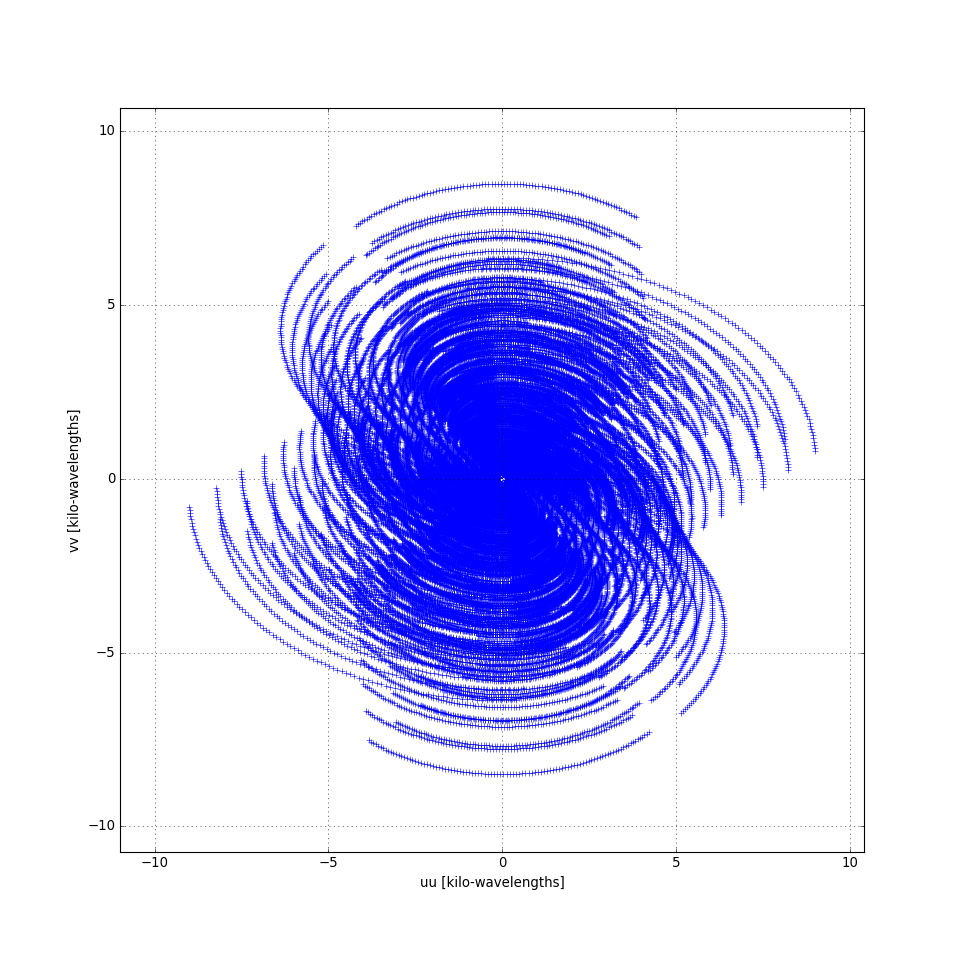

Exception ignored in: <bound method OskarBinary.__del__ of <util.read_oskar_vis.OskarVis object at 0x7fd6cdfb67b8>>
Traceback (most recent call last):
  File "../../util/read_oskar_vis.py", line 53, in __del__
    self.file_handle.close()
AttributeError: 'OskarVis' object has no attribute 'file_handle'


<IPython.core.display.Javascript object>


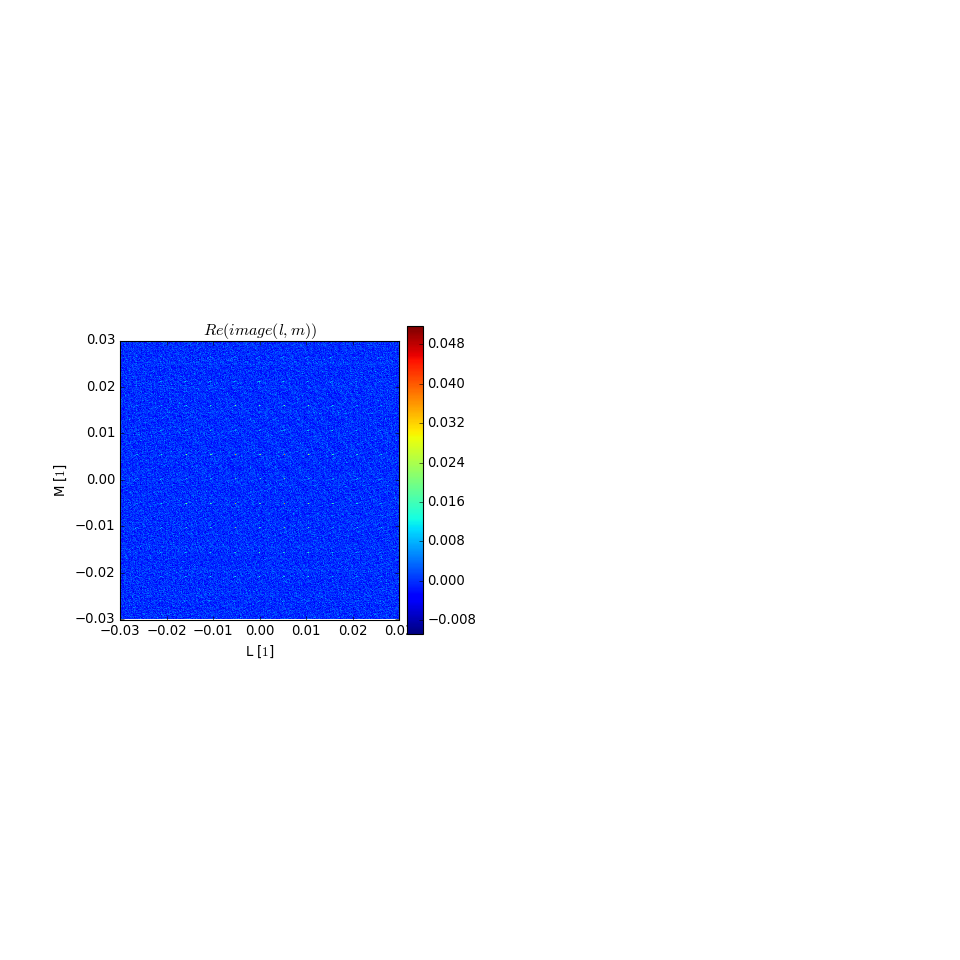

In [12]:
# uu-vv scatter plot.
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
ax.plot(uvw[0, :]/1.e3, uvw[1, :]/1.e3, 'b+')
ax.plot(-uvw[0, :]/1.e3, -uvw[1, :]/1.e3, 'b+')
ax.set_xlabel('uu [kilo-wavelengths]')
ax.set_ylabel('vv [kilo-wavelengths]')
ax.grid(True)

# uu-vv distance amplitude plot.
uvdist = (uvw[0, :]**2 + uvw[1, :]**2)**0.5
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(uvdist/1.e3, numpy.abs(amp), 'b+')
ax.set_xlabel('uu-vv distance [kilo-wavelengths]')
ax.set_ylabel('abs(visibility amplitude) [Janskys]')
ax.grid(True)

#### 4. Do imaging

In [13]:
from crocodile.synthesis import *
from util.visualize import *
theta = 2*0.03
lam = 2.01*numpy.max(numpy.abs(uvw))
d,p,_=doimg(theta, lam, numpy.transpose(uvw), rotw(-numpy.transpose(uvw), amp), simpleimg)
show_image(d, "image", theta)
plt.show()